# Data Processing

In [582]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statistics


In [583]:
scenario = 'usa-static-only'  # Replace with the word you're searching for
num_sims = 5

In [584]:

import os
import json

def find_json_files_containing_word(directory, word):
    matching_files = []
    
    # Walk through all files in the given directory and subdirectories
    for root, dirs, files in os.walk(directory):
        for file_name in files:
            if file_name.endswith('.json'):  # Only process JSON files
                file_path = os.path.join(root, file_name)
                
                try:
                    # Open and read the JSON file
                    with open(file_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                        # Check if the word is in the content
                        if word in file_name:
                            # Convert the JSON content into a Python dictionary
                            json_data = json.loads(content)
                            matching_files.append(json_data)
                except (UnicodeDecodeError, IOError, json.JSONDecodeError):
                    # Skip files that can't be read or are not valid JSON
                    continue

    return matching_files

# Example usage
directory_path = os.getcwd() # current directorry
matched_json_data = find_json_files_containing_word(directory_path, scenario)

# Print out the matching JSON files' data as Python dictionaries
len(matched_json_data)

5

In [585]:
print(matched_json_data[0].keys()) # 0-4
print(matched_json_data[0]["SimParams"].keys())
print(matched_json_data[0]["MarketHistory"][0].keys())
print(matched_json_data[0]["PlayerInformation"]['player(LOW0)'].keys())
print(matched_json_data[0]["PlayerHistories"]['player(LOW0)'][0].keys())
print(matched_json_data[0]["LotHistories"]['lot(0,0)'][0].keys())

dict_keys(['SimParams', 'MarketHistory', 'PlayerInformation', 'PlayerHistories', 'LotHistories'])
dict_keys(['numLots', 'numPeople', 'incomeDistribution', 'medianIncome', 'timeUnits', 'lotAttractiveness', 'playerSettings', 'dynamicPricingPercents'])
dict_keys(['moneyInHousingMarket', 'averageHousePrice', 'medianHousePrice', 'averageOwnedHousePrice', 'medianOwnedHousePrice', 'N_0', 'N_homeless'])
dict_keys(['income', 'relativeIncome', 'econRank'])
dict_keys(['expense', 'costliness', 'attractiveness', 'numMoves', 'qualityGoal', 'quality'])
dict_keys(['ownerIncome', 'currentPrice', 'attractiveness', 'PotentialBuyers'])


In [586]:
# helper functions

def make_history_dataframe(i, history_type, key, transform_func = lambda x: x):
    history_dict = matched_json_data[i][history_type]
    # Initialize an empty dictionary to store the values for the DataFrame
    data = {}
    # Iterate over each person and their list of dictionaries
    for person, list_of_dicts in history_dict.items():
        # Extract the values of 'c' from each dictionary in the list for the current person
        data[person] = [transform_func(d[key]) for d in list_of_dicts]
    # Convert the data dictionary to a pandas DataFrame
    df = pd.DataFrame(data)
    return df


def SNS_TIME_PLOT(data_sets, titles, colors, title, legend, xlim=(0,120), ylim=(0,1)):
    palette = {titles[i]: colors[i] for i in range(len(data_sets))}
    # Function to compute mean and standard deviation for each set
    def compute_mean_std(data_set, label):
        # Convert list of lists to a numpy array for easier computation
        data_array = np.array(data_set)
        
        # Calculate the mean and standard deviation for each index
        mean_values = np.mean(data_array, axis=0)
        std_values = np.std(data_array, axis=0)
        
        # Return as a DataFrame for easier plotting with Seaborn
        df = pd.DataFrame({
            'Index': range(len(mean_values)),
            'Mean': mean_values,
            'Std': std_values,
            'Set': label
        })
        return df

    # Compute mean and std for each set
    dfs = [compute_mean_std(data_sets[i], titles[i]) for i in range(len(data_sets))]

    # Concatenate all DataFrames into a single one for Seaborn
    df_all = pd.concat(dfs)

    # Create a plot with Seaborn
    plt.figure(figsize=(8, 6))

    # Plot the means with Seaborn's lineplot
    gfg = sns.lineplot(data=df_all, x='Index', y='Mean', hue='Set', 
                palette=palette, marker='o')
    gfg.set_xlim(*xlim)
    gfg.set_ylim(*ylim)

    # Now manually add the error bands (Standard Deviation) using fill_between
    for label in df_all['Set'].unique():
        # Extract the relevant subset of data for each set
        set_data = df_all[df_all['Set'] == label]
        
        # Plot a shaded area (error band) around the mean
        plt.fill_between(set_data['Index'], 
                        set_data['Mean'] - set_data['Std'], 
                        set_data['Mean'] + set_data['Std'], 
                        color=palette[label], alpha=0.3)  # Adjust the color and alpha for transparency

    # Add labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('Mean Value with Error Bars')
    
    plt.title(title)
    plt.legend(title=legend)

    # Show the plot
    plt.show()

# DISPLAY INCOME DISTRIBUTION

In [587]:
# 100,000 in circulation


# PER PRICING METHOD

In [588]:
# SORT PLAYERS INTO CLASSES ==================

i = 0

def class_df(i):
    dist = matched_json_data[i]["SimParams"]["incomeDistribution"]
    percentile_33 = np.percentile(dist, 33)
    percentile_66 = np.percentile(dist, 66)

    # sort by perentile...

    econ_class = dict({})

    for name, info in matched_json_data[i]["PlayerInformation"].items():
        _class = ""
        if info["income"] < percentile_33:
            _class = "Low Income"
        elif info["income"] > percentile_66:
            _class = "High Income"
        else:
            _class = "Middle Income"
        
        econ_class[name] = _class

    # Convert the dictionary to a DataFrame with Name as the index and Class as the value
    class_df = pd.DataFrame(list(econ_class.items()), columns=['Name', 'Class'])

    # Set 'Name' as the index and drop the 'Name' column
    class_df = class_df.set_index('Name')
    class_df['Class']
    return class_df

def avg_df(i):
    # simulation = matched_json_data[i]
    # player_info_df = pd.DataFrame(matched_json_data[i]["PlayerInformation"])


    # The DataFrame will automatically have the rows as people (keys) and columns as list indices (0 to 99)
    df2 = make_history_dataframe(i, "PlayerHistories", "attractiveness")
    df3 = make_history_dataframe(i, "PlayerHistories", "quality")
    df4 = make_history_dataframe(i, "PlayerHistories", "costliness")

    # ================
    # Step 1: Extract the last row (latest time) for both income and quality
    avg_attractive = df2.mean()  # Average income across all time points for each person
    avg_quality = df3.mean()
    avg_costliness = df4.mean()

    # Step 2: Create a new dataframe with the last values
    # Apply the transformation: income/5 and keep quality values as they are
    transformed_df = pd.DataFrame({
        'Average Attractiveness': avg_attractive,
        'Average Quality': avg_quality,
        'Average Costliness': avg_costliness
    })

    # cut out first value. everyones movin
    return transformed_df

def stable_unstable_df(i):
    stable_unstable = dict({})

    for name, hist in matched_json_data[i]["PlayerHistories"].items():
        num_years = matched_json_data[i]['SimParams']['timeUnits'] / 12

        _type = ""
        hist_df = pd.DataFrame(hist)
        homeless = hist_df['attractiveness'].tolist().count(-10) >= 12 # has been homeless for a year or more
        stable = hist_df['numMoves'].tail(1) <= num_years*2

        if homeless or not stable.any(): _type = "Unstable" #homeless: _type = "Unstable" # or not stable.any(): _type = "Unstable"
        else: _type = "Stable"

        stable_unstable[name] = _type
        
    # Convert the dictionary to a DataFrame with Name as the index and Class as the value
    df = pd.DataFrame(list(stable_unstable.items()), columns=['Name', 'Housing'])

    # Set 'Name' as the index and drop the 'Name' column
    df = df.set_index('Name')
    df['Housing']
    return df

def combine_class_df(i, func): # avg_df, stable_unstable_df
    df1, df2 = class_df(i), func(i)
    df2['Class'] = df1['Class']
    return df2


def summary_df(func, i):
    df = func(i)
    # Step 1: Group by Class and Type and count occurrences
    count_df = df.groupby(['Class', 'Type']).size().reset_index(name='Count')
    # Step 2: Calculate the total count for each Class
    class_total = df.groupby('Class').size().reset_index(name='Total')
    # Step 3: Merge the counts with the total counts
    merged_df = pd.merge(count_df, class_total, on='Class')
    # Step 4: Calculate the percentage for each Type within each Class
    merged_df['Percentage'] = (merged_df['Count'] / merged_df['Total'])
    # Step 5: Create the summary DataFrame with Class, Type, and Percentage
    summary_df = merged_df[['Class', 'Type', 'Percentage']]
    return summary_df

def combine_sims(func):
    dfs = [summary_df(func, i) for i in range(num_sims)]
    df = pd.concat(dfs, ignore_index=True)
    # Group by 'Class' and 'Type', then calculate mean and std of 'Percentage'
    result_df = df.groupby(['Class', 'Type'])['Percentage'].agg(['mean', 'std']).reset_index()
    return result_df

## 1. Housing Affordability v. Economic Class

In [589]:
def affordable_df(i):
    df = combine_class_df(i, avg_df)
    conditions = [
        (df['Average Quality'] <= -1.5),  # Homeless
        (df['Average Quality'] > -1.5) & (df['Average Costliness'] <= 0.75),  # Affordable
        (df['Average Quality'] > -1.5) & (df['Average Costliness'] > 0.75)  # Unaffordable
    ]
    values = ['Homeless', 'Affordable', 'Unaffordable']
    # Apply conditions
    df['Type'] = np.select(conditions, values, default='Unknown')
    return df


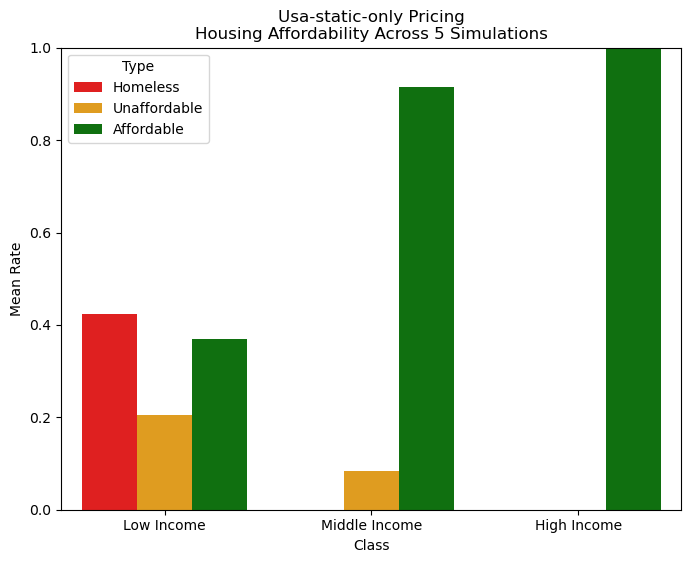

In [590]:
df = combine_sims(affordable_df)

# Define the custom order for 'Class' and 'Type'
class_order = ['Low Income', 'Middle Income', 'High Income']  # Order of classes
type_order = ['Homeless', 'Unaffordable', 'Affordable']  # Order of types
type_colors = ['red', 'orange', 'green']  # Custom colors for each type

# Set the color palette manually
palette = dict(zip(type_order, type_colors))

# Create the seaborn barplot
plt.figure(figsize=(8, 6))
gfg = sns.barplot(x='Class', y='mean', hue='Type', data=df,
            order=class_order, hue_order=type_order, palette=palette)
gfg.set(ylim=(0, 1))

# Customize plot
plt.title(f'{scenario.capitalize()} Pricing\nHousing Affordability Across {num_sims} Simulations')
plt.ylabel('Mean Rate')
plt.xlabel('Class')

plt.show()


## 2. Housing Types v. Economic Class

In [591]:
def attractive_df(i):
    df = combine_class_df(i, avg_df)
    conditions = [
        (df['Average Attractiveness'] <= -8),  # low quality
        (df['Average Attractiveness'] > -8) & (df['Average Attractiveness'] < 8),  # standard
        (df['Average Attractiveness'] >= 8)  # high quality
    ]
    values = ['Low', 'Standard', 'High']
    # Apply conditions
    df['Type'] = np.select(conditions, values, default='Unknown')
    return df

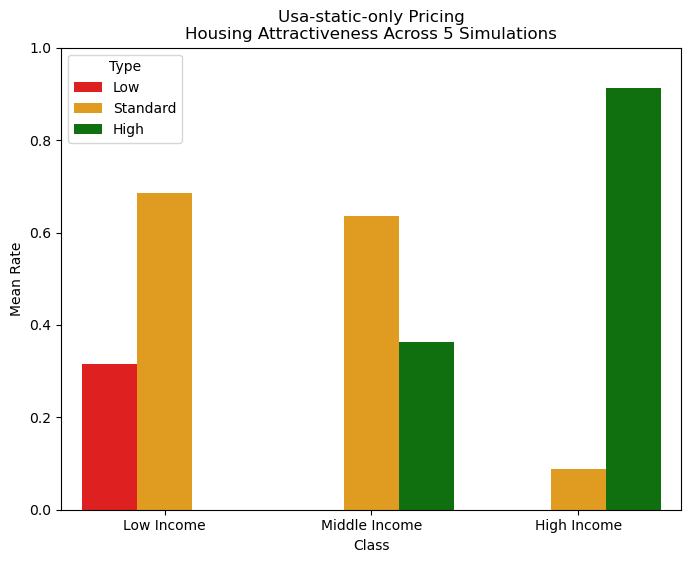

In [592]:
df = combine_sims(attractive_df)

# Define the custom order for 'Class' and 'Type'
class_order = ['Low Income', 'Middle Income', 'High Income']  # Order of classes
type_order = ['Low', 'Standard', 'High']  # Order of types
type_colors = ['red', 'orange', 'green']  # Custom colors for each type

# Set the color palette manually
palette = dict(zip(type_order, type_colors))

# Create the seaborn barplot
plt.figure(figsize=(8, 6))
gfg = sns.barplot(x='Class', y='mean', hue='Type', data=df,
            order=class_order, hue_order=type_order, palette=palette)
gfg.set(ylim=(0, 1))

# Customize plot
plt.title(f'{scenario.capitalize()} Pricing\nHousing Attractiveness Across {num_sims} Simulations')
plt.ylabel('Mean Rate')
plt.xlabel('Class')

plt.show()


## 3. QUALITY OF LIVIING v. Economic Class

In [593]:
thres = 0.75

def quality_df(i):
    df = combine_class_df(i, avg_df)
    conditions = [
        (df['Average Quality'] <= -thres),  # low quality
        (df['Average Quality'] > -thres) & (df['Average Attractiveness'] < thres),  # standard
        (df['Average Quality'] >= thres)  # high quality
    ]
    values = ['Low', 'Standard', 'High']
    # Apply conditions
    df['Type'] = np.select(conditions, values, default='Unknown')
    return df

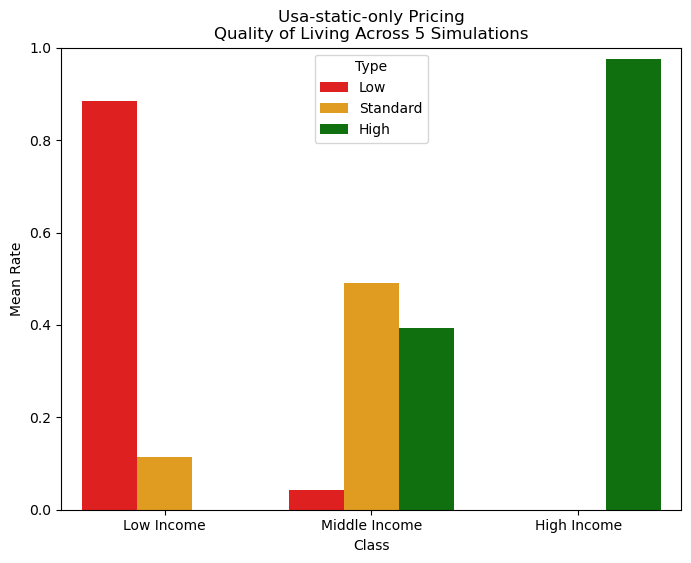

In [616]:
df = combine_sims(quality_df)

# Define the custom order for 'Class' and 'Type'
class_order = ['Low Income', 'Middle Income', 'High Income']  # Order of classes
type_order = ['Low', 'Standard', 'High']  # Order of types
type_colors = ['red', 'orange', 'green']  # Custom colors for each type

# Set the color palette manually
palette = dict(zip(type_order, type_colors))

# Create the seaborn barplot
plt.figure(figsize=(8, 6))
gfg = sns.barplot(x='Class', y='mean', hue='Type', data=df,
            order=class_order, hue_order=type_order, palette=palette)
gfg.set(ylim=(0, 1))


# Customize plot
plt.title(f'{scenario.capitalize()} Pricing\nQuality of Living Across {num_sims} Simulations')
plt.ylabel('Mean Rate')
plt.xlabel('Class')

plt.show()


## 4. STABLE HOUSING v ECON CLASS

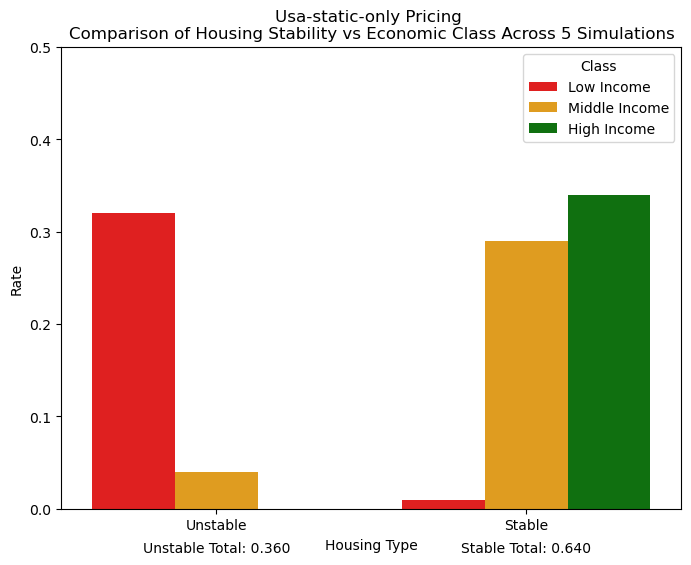

In [606]:
# scatter range
# stable housing: in 10 years => 10 or less moves
# unstable housing => more than 10 moves or has been homeless

df = pd.concat([combine_class_df(i, stable_unstable_df) for i in range(num_sims)], ignore_index=True)

count_data = df.groupby(['Housing', 'Class']).size().reset_index(name='count')
count_data['count'] /= 500
housing_totals = count_data.groupby('Housing')['count'].sum().reset_index(name='total_count')


# Define the custom order for 'class' and custom colors for the plot
class_order = ['Low Income', 'Middle Income', 'High Income']
class_colors = {'Low Income': 'red', 'Middle Income': 'orange', 'High Income': 'green'}
housing_order = ['Unstable', 'Stable']  

# Plot using Seaborn barplot
plt.figure(figsize=(8,6))
ax = sns.barplot(x='Housing', y='count', hue='Class', data=count_data, 
            hue_order=class_order, order=housing_order, palette=class_colors)

ax.set(ylim=(0, 0.5))


# Add custom legend for total counts
for idx, row in housing_totals.iterrows():
    # Get the x position of the bar (this is based on the index)
    x_pos = np.abs(idx-1)  # 'unstable' is 0, 'stable' is 1
    # Find the height of the top of the bars in each group
    total_height = row['total_count']
    # Add text above each bar, adjusting the position slightly higher
    ax.text(x=x_pos, y=-.05, 
            s=f"{row['Housing']} Total: {total_height:.3f}", 
            ha='center', va='bottom', color='black', fontsize=10)

# Add labels and title
plt.title(f'{scenario.capitalize()} Pricing \nComparison of Housing Stability vs Economic Class Across {num_sims} Simulations')
plt.xlabel('Housing Type')
plt.ylabel('Rate')

# Show the plot
plt.show()


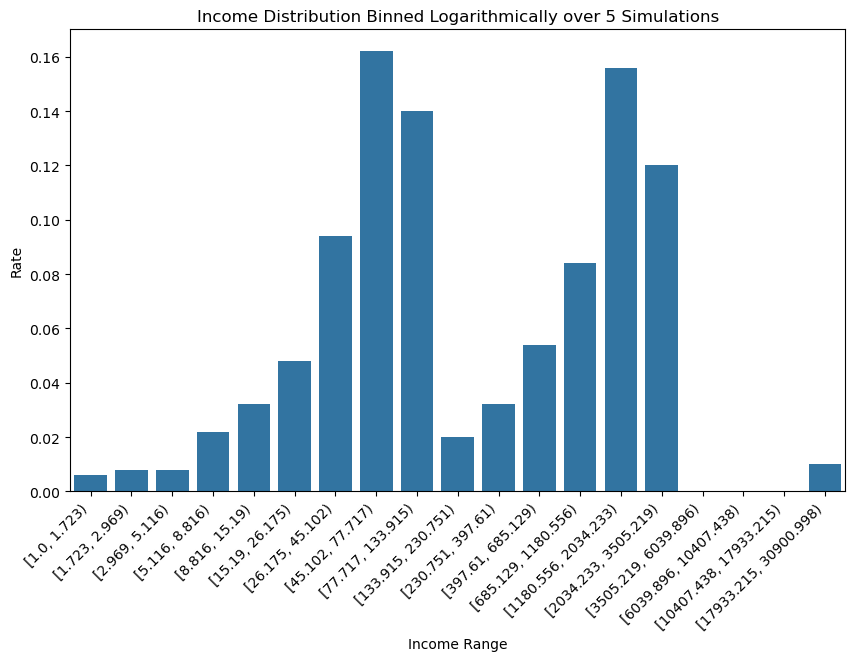

In [596]:
# graph 1: distribution of house 
# bins:  attractiveness => / divide by time units
incomes = [matched_json_data[i]['SimParams']['incomeDistribution'] for i in range(num_sims)]
incomes = [item for row in incomes for item in row]
num_people = 500

# Convert the list into a pandas DataFrame
df = pd.DataFrame(incomes, columns=['income'])

bins = np.logspace(np.log10(1), np.log10(max(incomes)+1), num=20)

# Bin the income data into these logarithmic bins
df['income_bins'] = pd.cut(df['income'], bins=bins, right=False)

# Count the number of incomes in each bin
bin_counts = df['income_bins'].value_counts().sort_index()
bin_counts /= num_people

# Plot the barplot (binned data)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=bin_counts.index.astype(str), y=bin_counts.values)

plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.title(f'Income Distribution Binned Logarithmically over {num_sims} Simulations')
plt.xlabel('Income Range')
plt.ylabel('Rate')

# Show the plot
plt.show()


# graph 2: distribution of house costs
# bins: cost (relative to median) => / divide by time units

# TRAD V DYNAMIC

In [597]:
# graph1: scatter plot of homelessness

# y: homelessness
# x: [static]  [dynamic]

In [598]:
# graph 1:
# comparison
# money held in the market over time

# y: percent of money held in the market
# x: [static]  [dynamic]

# avg house price vs avg owned house price
# median hosue price vs median owned house price

# OLD GRAPHS

## Graph 1: Housing Rates v Time

In [599]:
# data transform
"""
GRAPH 1:

Affordable housing rate: # of people spend less than 0.75 of income [minus homeless lots] / # people		ORANGE
At risk of Homeless rate: # of people who are [-10,-5 quality] / # people		RED
"""
i = 0

# Moving rate: # of people who move / # people	GREEN

def transformed_housing_rate(i):
    simulation = matched_json_data[i]
    num_people = simulation['SimParams']['numPeople']

    # The DataFrame will automatically have the rows as people (keys) and columns as list indices (0 to 99)
    num_moves_df = make_history_dataframe(i, "PlayerHistories", "numMoves")
    # we set the default for the median income person's house to be 0.75 costliness. also cost == 0 means that theyre homeless lol
    affordable_df = make_history_dataframe(i, "PlayerHistories", "costliness", lambda x: 0 < x <= 0.75) 
    unafforadable_df = make_history_dataframe(i, "PlayerHistories", "costliness", lambda x: 0.75 < x) 
    # homeless_df = make_history_dataframe(i, "PlayerHistories", "quality", lambda x: x == -2)
    homeless_df = make_history_dataframe(i, "PlayerHistories", "quality", lambda x: x == -2)

    # transform the num_moves_df to true/false based on if number of moves changed
    # Create a new DataFrame where values indicate whether the value has changed from the previous row
    moved_df = num_moves_df.ne(num_moves_df.shift()).astype(int)  # ne (not equal) checks for changes, converts to int (True/False)
    # Now, you can convert 1 (True) to True and 0 (False) to False for clarity if needed
    didnt_move_df = ~moved_df.astype(bool) # inversers the bool

    # ================
    # Count the number of True values per row
    stable_housing_rate = (didnt_move_df.sum(axis=1) / num_people).tolist()
    affordable_rate = (affordable_df.sum(axis=1) / num_people).tolist()
    homeless_rate = (homeless_df.sum(axis=1) / num_people).tolist()
    unafforadable_rate = (unafforadable_df.sum(axis=1) / num_people).tolist()

    # cut out first value. everyones movin
    return stable_housing_rate[1:], affordable_rate[1:], homeless_rate[1:], unafforadable_rate[1:]

stable_housing_rates, affordable_rates, homeless_rates, unafforadable_df = [], [], [], []

for i in range(num_sims):
    s, a, h, u = transformed_housing_rate(i)
    stable_housing_rates.append(s)
    affordable_rates.append(a)
    homeless_rates.append(h)
    unafforadable_df.append(u)


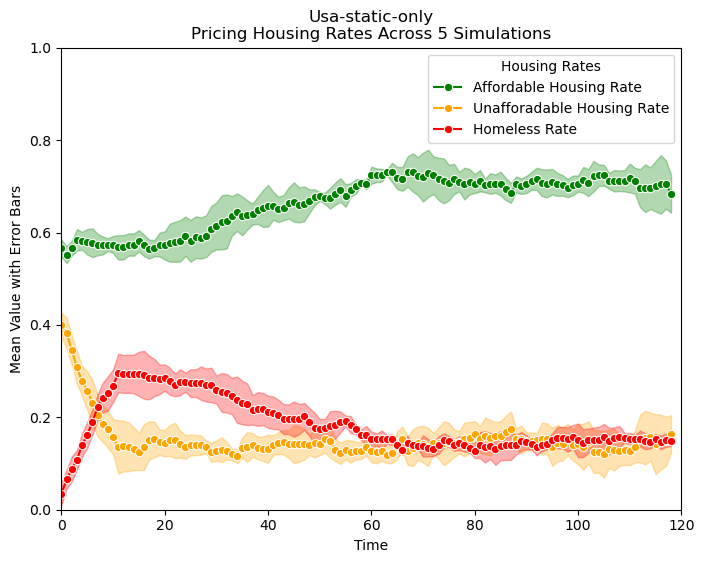

In [600]:
# SNS: ALL SIM. PLOT =================================

SNS_TIME_PLOT([affordable_rates, unafforadable_df, homeless_rates],
         ['Affordable Housing Rate', 'Unafforadable Housing Rate', 'Homeless Rate'],
         ['green', 'orange', 'red'],
         f'{scenario.capitalize()}\nPricing Housing Rates Across {num_sims} Simulations',
         'Housing Rates')


## Graph 2: Gentrification Rates v Time

In [601]:
# data transform
"""
GRAPH 2:
Gentrified housing rate: # of people [8,10] housing / # people
Standard housing rate: # of people [-8,8] housing / # people
At homeless/at risk rate: # of people [-10,-8] housing / # people
"""
i = 0

# Moving rate: # of people who move / # people	GREEN

def transformed_housing_rate(i):
    simulation = matched_json_data[i]
    num_people = simulation['SimParams']['numLots']

    # The DataFrame will automatically have the rows as people (keys) and columns as list indices (0 to 99)
    gentrified_housing_df = make_history_dataframe(i, "LotHistories", "attractiveness", lambda x: x == 10)
    standard_housing_df = make_history_dataframe(i, "LotHistories", "attractiveness", lambda x: -10 < x < 10)
    at_risk_housing_df = make_history_dataframe(i, "LotHistories", "attractiveness", lambda x: x == -10)

    # ================
    # Count the number of True values per row
    gentrified_housing_rate = (gentrified_housing_df.sum(axis=1) / num_people).tolist()
    standard_housing_rate = (standard_housing_df.sum(axis=1) / num_people).tolist()
    at_risk_housing_rate = (at_risk_housing_df.sum(axis=1) / num_people).tolist()

    # cut out first value. everyones movin
    return gentrified_housing_rate[1:], standard_housing_rate[1:], at_risk_housing_rate[1:]

gentrified_housing_rates, standard_housing_rates, at_risk_housing_rates = [], [], []

for i in range(num_sims):
    s, a, h = transformed_housing_rate(i)
    gentrified_housing_rates.append(s)
    standard_housing_rates.append(a)
    at_risk_housing_rates.append(h)


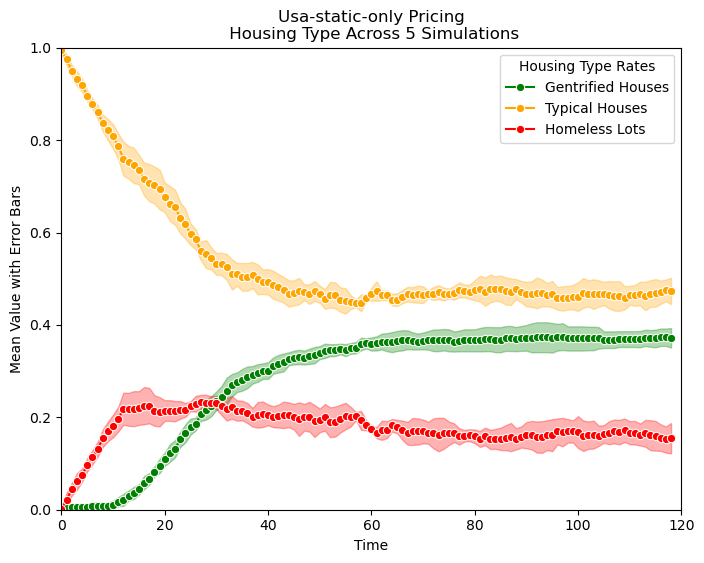

In [602]:
# SNS: ALL SIM. PLOT =================================

SNS_TIME_PLOT([gentrified_housing_rates, standard_housing_rates, at_risk_housing_rates],
         ['Gentrified Houses', 'Typical Houses', 'Homeless Lots'],
         ['green', 'orange', 'red'],
         f'{scenario.capitalize()} Pricing\n Housing Type Across {num_sims} Simulations',
         'Housing Type Rates',
         )

## Graph 3.1: Attractive vs income/median scatter pot

In [603]:
# Graph 3: Attractive vs income/median scatter pot
# at the end of 100 time units, what kind of house do they have?


def transformed_scatter(i):
    simulation = matched_json_data[i]
    median_income = simulation['SimParams']['medianIncome']
    player_info_df = pd.DataFrame(matched_json_data[i]["PlayerInformation"])


    # The DataFrame will automatically have the rows as people (keys) and columns as list indices (0 to 99)
    df2 = make_history_dataframe(i, "PlayerHistories", "attractiveness")
    df3 = make_history_dataframe(i, "PlayerHistories", "quality")
    df4 = make_history_dataframe(i, "PlayerHistories", "costliness")
    df5 = make_history_dataframe(i, "PlayerHistories", "qualityGoal")

    # ================
    # Step 1: Extract the last row (latest time) for both income and quality
    avg_attractive = df2.mean()  # Average income across all time points for each person
    avg_quality = df3.mean()
    avg_costliness = df4.mean()
    avg_quality_goal = df5.mean()

    # Step 2: Create a new dataframe with the last values
    # Apply the transformation: income/5 and keep quality values as they are
    transformed_df = pd.DataFrame({
        'Econ Rank': player_info_df.loc["econRank"],  # Divide income by 5
        'Relative Income': player_info_df.loc["relativeIncome"],  # Divide income by 5
        'Average Attractiveness': avg_attractive,
        'Average Quality': avg_quality,
        'Average Quality Goal': avg_quality_goal,
        'Average Costliness': avg_costliness
    })


    # cut out first value. everyones movin
    return transformed_df
dfs = []
for i in range(num_sims):
    dfs.append(transformed_scatter(i))
# Display the transformed dataframe
dfs[0]


,Econ Rank,Relative Income,Average Attractiveness,Average Quality,Average Quality Goal,Average Costliness
player(LOW0),-0.998642,0.225215,-7.275000,-1.536940,-0.762743,0.905131
player(LOW1),-0.995446,0.659331,-4.591667,-0.157048,0.270591,0.595985
player(LOW2),-0.995707,0.623930,-3.991667,-0.729718,-0.267582,0.675074
player(LOW3),-0.996362,0.535016,-5.308333,-0.565858,0.035426,0.643402
player(LOW4),-0.999604,0.094502,-8.875000,-1.895833,-1.162196,0.817041
...,...,...,...,...,...,...
player(MID45),-0.839349,21.864466,9.308333,0.922500,0.771833,0.061768
player(MID46),-0.888604,15.173375,9.141667,0.906667,0.705714,0.088598
player(MID47),-0.857299,19.425909,9.058333,0.899167,0.705437,0.068471
player(MID48),-0.935168,8.847824,9.083333,0.898333,0.724195,0.150680


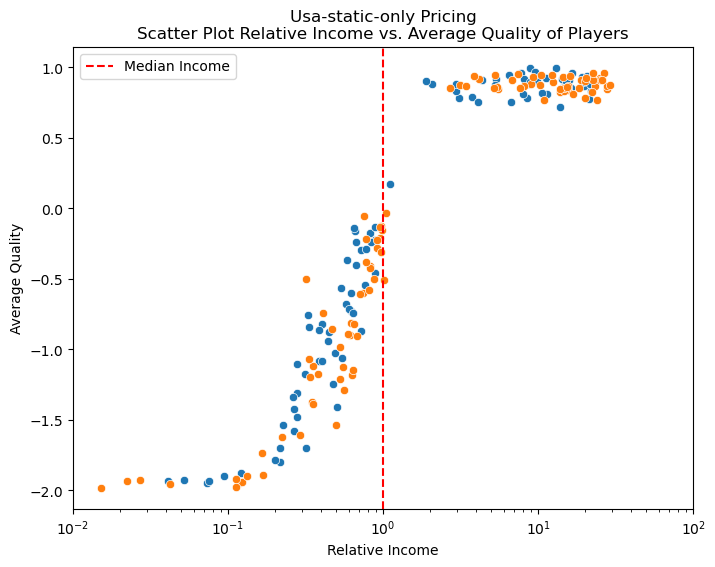

In [604]:
# Create the scatter plot using Seaborn
x = "Relative Income"
y = "Average Quality"
y_lim = None #[0,]


from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(8, 6))
gfg = sns.scatterplot(data=dfs[0][:-1], x=x, y=y)
gfg = sns.scatterplot(data=dfs[1][:-1], x=x, y=y)

if (y_lim): gfg.set_ylim(*y_lim)
plt.xscale('log')
plt.xlim(10**-2, 10**2)

# Add labels and title
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{scenario.capitalize()} Pricing\nScatter Plot {x} vs. {y} of Players')

# Add a red vertical line at x = 1
plt.axvline(x=1, color='red', linestyle='--', label='Median Income')

#===================================  Define a custom transformation for the x-axis ===================================

# def custom_transform(x):
#     # Scale the x-values to fit [0, 1] into the first half
#     return np.log1p(x)  # log(1 + x) scales [0,1] nicely and stretches [1, 40]
# # Apply custom transformation
# plt.gca().set_xlim([custom_transform(0), custom_transform(50)])
# # Format the x-axis labels to show the original x-values
# def format_x_ticks(x, pos):
#     return round(np.expm1(x), 2)  # Reverse the log transformation to show original values
# plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))


plt.legend()
# Show the plot
plt.show()


In [605]:
# scatter plot of house costs owned by people
# points: lots / people ( green (rich), orange (median), red (low))
# x: time
# y: cost/median

# track median house price